In [79]:
import os
import gradio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image, ImageChops
from sklearn.model_selection import train_test_split

In [80]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()

        # Encoder
        self.input_to_hidden = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_log_var = torch.nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.latent_to_hidden = torch.nn.Linear(latent_dim, hidden_dim)
        self.hidden_to_output = torch.nn.Linear(hidden_dim, input_dim)

        self.optimizer = torch.optim.Adam(self.parameters())

    def Encoder(self, x):
        h = self.input_to_hidden(x)
        mu = self.hidden_to_mu(h)
        log_var = self.hidden_to_log_var(h)
        return mu, log_var

    def Decoder(self, z):
        h = self.latent_to_hidden(z)
        x_hat = torch.sigmoid(self.hidden_to_output(h))
        return x_hat

    def forward(self, X):
        mu, log_var = self.Encoder(X)
        z = self.reparameterize(mu, log_var)
        x_hat = self.Decoder(z)
        return x_hat, mu, log_var

    def loss_function(self, X, x_hat, mu, log_var):
        BCE = torch.nn.functional.mse_loss(x_hat, X, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))
        return BCE + KLD

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def accuracy(self, X, x_hat):
        X = torchvision.transforms.functional.to_pil_image(X)
        x_hat = torchvision.transforms.functional.to_pil_image(x_hat)
        diff = ImageChops.difference(X, x_hat)
        rms = diff.rms  # Calculate RMS value
        return rms

    def Train(self, X, epochs=100):
        history = []
        x_hat = None
        self.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            x_hat, mean, log_var = self.forward(X)
            loss = self.loss_function(X, x_hat, mean, log_var)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
            history.append(loss.item())

        plt.plot(history)
        return history, x_hat

In [81]:
torch.cuda.is_available()

True

In [82]:
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist, shuffle=True, batch_size=mnist.train_data.shape[0])
image, label = next(iter(train_loader))

In [83]:
# Transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Resize((800, 800)),
#     torchvision.transforms.ToPILImage(mode='RGB')
# ])

In [84]:
# dataFromLocal = torchvision.datasets.ImageFolder(root='./data/toys_dataset/images', transform=Transform)
# dataLoader = torch.utils.data.DataLoader(dataFromLocal, shuffle=True, batch_size=300)

In [85]:
# dataLoader.dataset[-1][0]

In [86]:
pathToLocalToPanda = '../toys_dataset/images/Panda/'
pathToLocalToRabbit = '../toys_dataset/images/Rabbit/'

pathToKaggleToPanda = '/kaggle/input/toys-images/images/Panda/'
pathToKaggleToRabbit = '/kaggle/input/toys-images/images/Rabbit/'

pathToPanda = pathToLocalToPanda if os.path.exists(pathToLocalToPanda) else pathToKaggleToPanda
pathToRabbit = pathToLocalToRabbit if os.path.exists(pathToLocalToRabbit) else pathToKaggleToRabbit

In [87]:
images_panda = np.zeros((105, 3 * 100 * 100))
images_rabbit = np.zeros((150, 3 * 100 * 100))

for i, img in enumerate(os.listdir(pathToPanda)):
    im = Image.open(pathToPanda + img)
    im = im.resize((100, 100))
    images_panda[i] = np.array(im).reshape(3 * 100 * 100)
for i, img in enumerate(os.listdir(pathToRabbit)):
    im = Image.open(pathToRabbit + img)
    im = im.resize((100, 100))
    images_rabbit[i] = np.array(im).reshape(3 * 100 * 100)

In [88]:
images_panda = images_panda / 255.
images_rabbit = images_rabbit / 255.

In [89]:
images_panda.shape, images_rabbit.shape

((105, 30000), (150, 30000))

In [90]:
images = np.concatenate((images_panda, images_rabbit))

In [91]:
images = torch.from_numpy(images)

In [92]:
images = images.to(torch.float32)

In [97]:
images.shape

torch.Size([255, 30000])

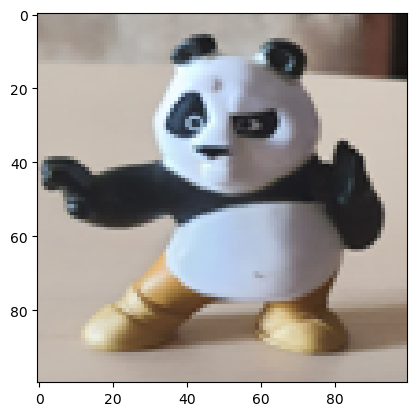

In [98]:
plt.imshow(images[2].reshape(100, 100, 3))

In [99]:
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42, shuffle=True)

In [100]:
x_train.shape, x_test.shape

(torch.Size([204, 30000]), torch.Size([51, 30000]))

In [117]:
latent_dim = 10
model = VAE(input_dim=30000, hidden_dim=300, latent_dim=latent_dim)

In [118]:
model

VAE(
  (input_to_hidden): Linear(in_features=30000, out_features=300, bias=True)
  (hidden_to_mu): Linear(in_features=300, out_features=10, bias=True)
  (hidden_to_log_var): Linear(in_features=300, out_features=10, bias=True)
  (latent_to_hidden): Linear(in_features=10, out_features=300, bias=True)
  (hidden_to_output): Linear(in_features=300, out_features=30000, bias=True)
)

Epoch: 0, Loss: 278811.25
Epoch: 1, Loss: 280560.5
Epoch: 2, Loss: 227101.0
Epoch: 3, Loss: 264713.09375
Epoch: 4, Loss: 239828.0
Epoch: 5, Loss: 253802.9375
Epoch: 6, Loss: 251525.03125
Epoch: 7, Loss: 270395.59375
Epoch: 8, Loss: 278901.15625
Epoch: 9, Loss: 249390.3125
Epoch: 10, Loss: 239476.625
Epoch: 11, Loss: 244955.125
Epoch: 12, Loss: 236781.03125
Epoch: 13, Loss: 239801.90625
Epoch: 14, Loss: 239009.734375
Epoch: 15, Loss: 251919.5625
Epoch: 16, Loss: 246516.546875
Epoch: 17, Loss: 251905.640625
Epoch: 18, Loss: 245702.296875
Epoch: 19, Loss: 238431.125
Epoch: 20, Loss: 230914.96875
Epoch: 21, Loss: 236750.65625
Epoch: 22, Loss: 229399.375
Epoch: 23, Loss: 224965.953125
Epoch: 24, Loss: 225012.484375
Epoch: 25, Loss: 228996.703125
Epoch: 26, Loss: 225055.65625
Epoch: 27, Loss: 222195.4375
Epoch: 28, Loss: 222897.0
Epoch: 29, Loss: 223564.0625
Epoch: 30, Loss: 220780.0625
Epoch: 31, Loss: 218474.84375
Epoch: 32, Loss: 220690.703125
Epoch: 33, Loss: 217152.3125
Epoch: 34, Loss:

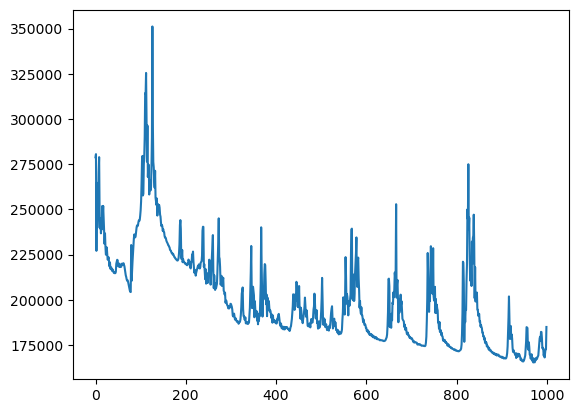

In [141]:
_, x_reconstructed = model.Train(x_train, epochs=1000)

In [120]:
x_reconstructed.shape

torch.Size([204, 30000])

In [121]:
x_reconstructed[0].shape

torch.Size([30000])

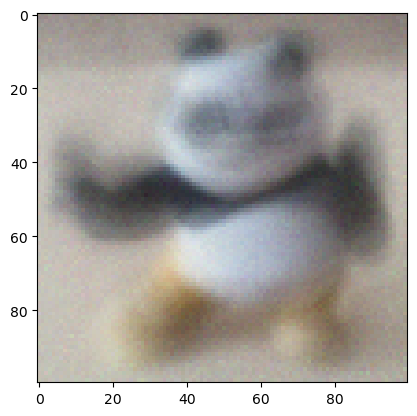

In [122]:
plt.imshow(x_reconstructed[0].detach().numpy().reshape(100, 100, 3))

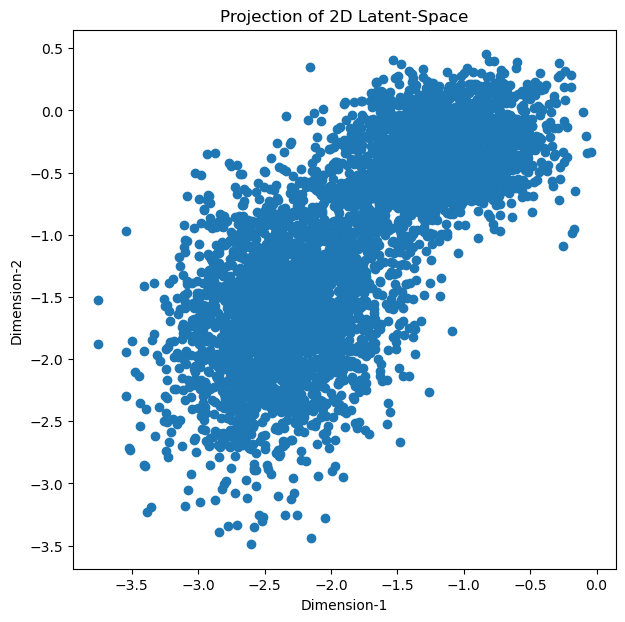

In [123]:
n_to_show = 5000

example_idx = np.random.choice(range(len(x_train)), n_to_show)
example_images = x_train[example_idx]

m, v = model.Encoder(example_images)
embeddings = model.reparameterize(m, v)
embeddings = embeddings.detach().numpy()
plt.figure(figsize=(7, 7))

plt.scatter(embeddings[:, 0], embeddings[:, 1])
plt.xlabel("Dimension-1")
plt.ylabel("Dimension-2")
plt.title("Projection of 2D Latent-Space")
plt.show()

In [124]:
embeddings.shape

(5000, 10)

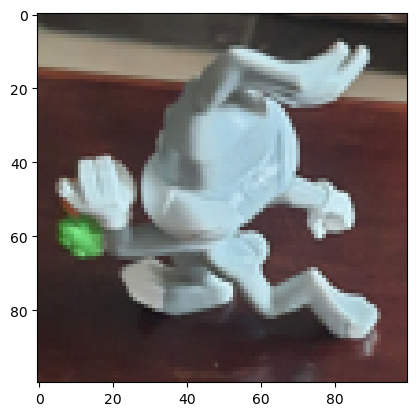

In [129]:
plt.imshow(example_images[0].reshape(100, 100, 3))

In [126]:
def plotting(num_images=10):
    plt.figure(figsize=(20, 20))
    plt.gcf()
    for i in range(num_images):
        img = np.random.randint(0, 204, size=1)
        # display original
        ax = plt.subplot(10, 2, 2 * i + 1)
        plt.imshow(x_train[img].reshape(100, 100, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(10, 2, 2 * i + 2)
        plt.imshow(x_reconstructed[img].detach().numpy().reshape(100, 100, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig = plt.gcf()
    fig.savefig('Reconstructed.jpeg')
    plt.show()
    return Image.open('Reconstructed.jpeg')

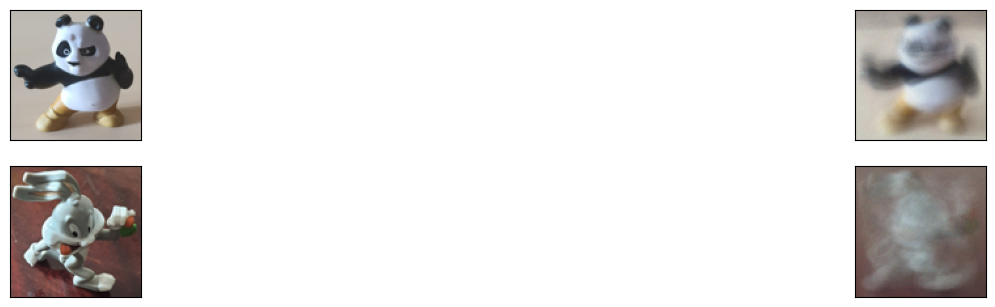

In [127]:
created_image = plotting(2)

In [134]:
n = 5
z_sample = np.random.normal(size=(n, latent_dim))
z_sample = torch.from_numpy(z_sample).float()
x_decoded = model.Decoder(z_sample)

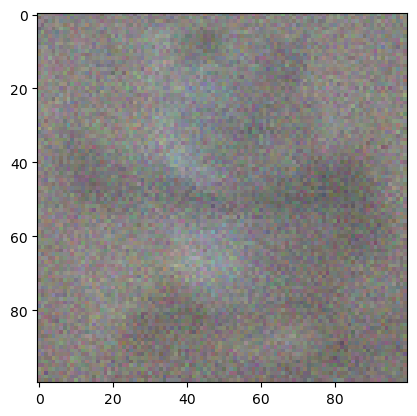

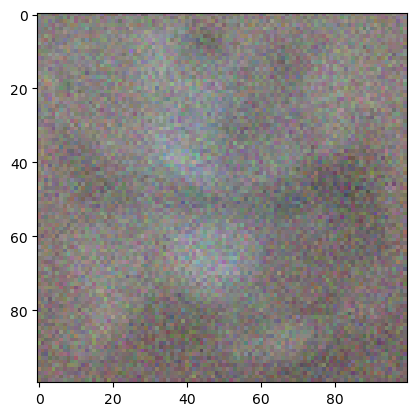

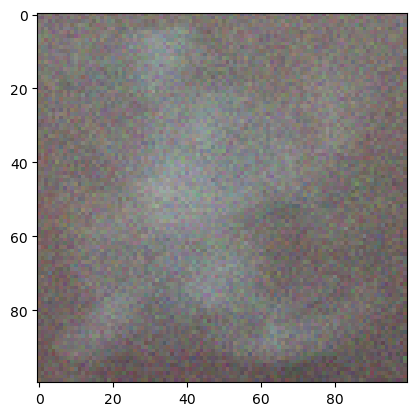

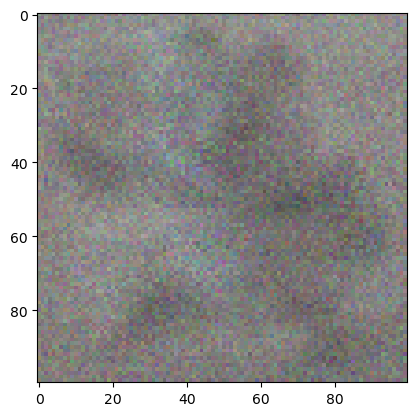

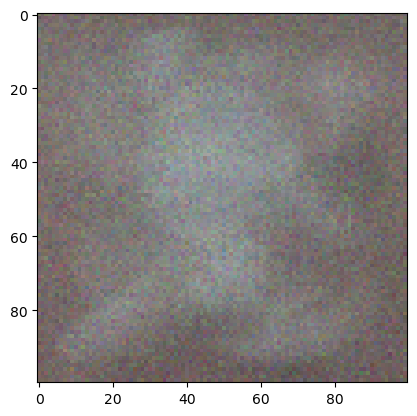

In [139]:
for i in range(n):
    plt.imshow(x_decoded[i].detach().numpy().reshape(100, 100, 3))
    plt.show()

In [136]:
interface = gradio.Interface(plotting, gradio.Slider(1, 10, label="Choose number images", step=1), gradio.Image(label="Reconstructed Images", show_label=True))

In [137]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Missing file: C:\Users\moham\anaconda3\Lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: C:\Users\moham\anaconda3\Lib\site-packages\gradio
